In [2]:
# import sys
# !{sys.executable} -m pip install matplotlib


In [4]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, LogitsProcessor, LogitsProcessorList
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import gc
from scipy.stats import ttest_ind
import numpy as np
import re  # For parsing the solution steps
from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt
from random import seed, randint
import os



In [2]:
def load_and_preprocess_aime_dataset(model_name, split="train"):
    """Loads and preprocesses the AIME dataset from Hugging Face.
    
    Args:
        model_name: The name of the Hugging Face model (for tokenizer compatibility).
        split: The dataset split to load (default is 'train').
        
    Returns:
        A tuple (processed_data, tokenizer) where processed_data is a list of dictionaries.
    """
    try:
        # Load the AIME dataset
        dataset = load_dataset("di-zhang-fdu/AIME_1983_2024", split=split)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        processed_data = []
        for example in dataset:
            # Extract fields using the correct keys from the dataset
            question = example['Question']
            answer = example['Answer']
            year = example['Year']
            problem_number = example['Problem Number']
            problem_id = f"{year}-{problem_number}"
            
            # Clean LaTeX if needed
            question = question.replace("\\$", "$")
            answer = answer.replace("\\$", "$")
            
            # Format the input prompt including the directive for reasoning and final answer formatting.
            input_prompt = (
                f"AIME Problem {problem_number} ({year}):\n{question}\n\n"
                "Solution:\nPlease reason step by step, and put your final answer within \\boxed{}.\n"
                "<think>\n"
                "****\n"
                "*****\n"
                "</think>\n"
            )
            
            # Tokenize the prompt
            tokenized_input = tokenizer(input_prompt, return_tensors="pt")
            
            processed_data.append({
                'problem': question,
                'solution': answer,
                'year': year,
                'problem_number': problem_number,
                'problem_id': problem_id,
                'input_prompt': input_prompt,
                'tokenized_input': tokenized_input,
            })
        
        print(f"Successfully processed {len(processed_data)} AIME problems")
        return processed_data, tokenizer
    
    except Exception as e:
        print(f"Error loading AIME dataset: {str(e)}")
        return None, None


# Example usage:
# processed_data, tokenizer = load_and_preprocess_aime_dataset("gpt2", split="train")
# Example usage:
# processed_data, tokenizer = load_and_preprocess_aime_dataset("gpt2", split="train")

In [4]:
def extract_boxed_answer(solution_text):
    """
    Extracts the answer that appears inside \boxed{} in LaTeX solutions.
    
    Args:
        solution_text: The full solution text containing a boxed answer.
        
    Returns:
        The extracted answer as a string, or None if no boxed answer is found.
    """
    import re
    
    # Pattern to match content inside \boxed{...}
    pattern = r'\\boxed\{([^{}]+)\}'
    
    # Search for the pattern
    match = re.search(pattern, solution_text)
    
    if match:
        # Return the content inside the boxed environment
        return match.group(1).strip()
    else:
        # Try alternative pattern for cases where there might be nested braces
        alt_pattern = r'\\boxed\{([^{}]*(?:\{[^{}]*\}[^{}]*)*)\}'
        alt_match = re.search(alt_pattern, solution_text)
        
        if alt_match:
            return alt_match.group(1).strip()
        
        return None

## Baseline

In [44]:
model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# Load and preprocess the AIME dataset
processed_data, tokenizer = load_and_preprocess_aime_dataset(model_name, split="train")
if processed_data is None:
    raise ValueError("Dataset loading failed.")

set_seed(42)  # For reproducibility

# Initialize the vLLM model with a maximum model length
model = LLM(model=model_name, max_model_len=16048)

# Generation parameters
temperature = 0.6
top_p = 0.95
max_new_tokens = 15000
num_examples = 50

# Collect input prompts for the batch
batch_prompts = [example["input_prompt"] for example in processed_data[:num_examples]]

# Define sampling parameters for generation
sampling_params = SamplingParams(
    temperature=temperature,
    top_p=top_p,
    max_tokens=max_new_tokens
)

# Generate outputs for the entire batch using vLLM
results = model.generate(batch_prompts, sampling_params)

# correct_count = 0
# total = 0

# # Iterate over each example in the batch along with its result
# for idx, (example, result) in enumerate(zip(processed_data[:num_examples], results)):
#     generated_text = result.text  # Extract generated text for the example
#     final_answer = extract_boxed_answer(generated_text)

#     print(f"\n=== AIME Problem {example['problem_number']} ({example['year']}) ===")
#     print("Input Prompt:")
#     print(example["input_prompt"])
#     print("\nGenerated Thinking Trace and Full Output:")
#     print(generated_text)
#     if final_answer:
#         print("\nExtracted Final Answer:")
#         print(final_answer)
#     else:
#         print("\nFinal answer could not be extracted (no \\boxed{{}} found).")

#     # Simple accuracy calculation (case-insensitive)
#     ground_truth = example["solution"].strip().lower()
#     extracted = final_answer.strip().lower() if final_answer else ""
#     if extracted == ground_truth:
#         correct_count += 1
#     total += 1

# accuracy = (correct_count / total) * 100 if total > 0 else 0.0
# print(f"\nAccuracy over {total} examples: {accuracy:.2f}%")

# # Cleanup: delete temporary objects and clear GPU memory
# del batch_prompts, results, sampling_params
# gc.collect()
# torch.cuda.empty_cache()

# # Final cleanup: delete the model and clear all remaining GPU memory
# del model
# gc.collect()
# torch.cuda.empty_cache()

Successfully processed 933 AIME problems
INFO 02-27 14:06:08 config.py:549] This model supports multiple tasks: {'score', 'generate', 'reward', 'embed', 'classify'}. Defaulting to 'generate'.
INFO 02-27 14:06:08 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=16048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_t

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 02-27 14:06:12 model_runner.py:1115] Loading model weights took 14.9576 GB
INFO 02-27 14:06:13 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-27 14:06:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.90) = 71.27GiB
INFO 02-27 14:06:13 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 1.66GiB; the rest of the memory reserved for KV Cache is 54.66GiB.
INFO 02-27 14:06:14 executor_base.py:111] # cuda blocks: 27984, # CPU blocks: 2048
INFO 02-27 14:06:14 executor_base.py:116] Maximum concurrency for 16048 tokens per request: 27.90x
INFO 02-27 14:06:14 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:22<00:00,  1.56it/s]

INFO 02-27 14:06:36 model_runner.py:1562] Graph capturing finished in 22 secs, took 0.09 GiB
INFO 02-27 14:06:36 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 23.91 seconds



Processed prompts: 100%|██████████| 50/50 [03:57<00:00,  4.75s/it, est. speed input: 26.35 toks/s, output: 1557.26 toks/s]


In [45]:
# Define a function to calculate thinking trace length
def extract_thinking_trace(generated_text):
    """
    Extracts the thinking trace portion and calculates its length.
    Thinking trace is everything from the start up to "</think>"
    
    Args:
        generated_text: The full generated text
        
    Returns:
        A tuple of (thinking_trace_length, non_thinking_length)
    """
    think_end = generated_text.find("</think>")
    
    if think_end != -1:
        # Everything up to and including </think> is the thinking trace
        thinking_trace_len = think_end + 8  # +8 to include "</think>"
        
        # Everything after </think> is non-thinking
        non_thinking_text = generated_text[think_end + 8:]
        non_thinking_len = len(non_thinking_text)
        
        return thinking_trace_len, non_thinking_len
    else:
        # No "</think>" tag found, all text is considered non-thinking
        return 0, len(generated_text)

# Initialize variables for tracking lengths
thinking_trace_lengths = []
non_thinking_lengths = []
correct_count = 0
total = 0

for idx, (example, result) in enumerate(zip(processed_data[:num_examples], results)):
    generated_text = result.outputs[0].text  # Extract generated text for the example
    final_answer = extract_boxed_answer(generated_text)
    
    # Extract thinking trace and calculate lengths
    think_len, non_think_len = extract_thinking_trace(generated_text)
    thinking_trace_lengths.append(think_len)
    non_thinking_lengths.append(non_think_len)

    # print(f"\n=== AIME Problem {example['problem_number']} ({example['year']}) ===")
    # print("Input Prompt:")
    # print(example["input_prompt"])
    # print("\nGenerated Thinking Trace and Full Output:")
    # print(generated_text)
    # if final_answer:
    #     print("\nExtracted Final Answer:")
    #     print(final_answer)
    # else:
    #     print("\nFinal answer could not be extracted (no \\boxed{{}} found).")
    
    # print(f"\nThinking trace length: {think_len} characters")
    # print(f"Non-thinking text length: {non_think_len} characters")

    # Simple accuracy calculation (case-insensitive)
    ground_truth = example["solution"].strip().lower()
    extracted = final_answer.strip().lower() if final_answer else ""
    if extracted == ground_truth:
        correct_count += 1
    total += 1

# Calculate averages
avg_thinking_trace_len = sum(thinking_trace_lengths) / len(thinking_trace_lengths) if thinking_trace_lengths else 0
avg_non_thinking_len = sum(non_thinking_lengths) / len(non_thinking_lengths) if non_thinking_lengths else 0

# Print statistics
accuracy = (correct_count / total) * 100 if total > 0 else 0.0
print(f"\nAccuracy over {total} examples: {accuracy:.2f}%")
print(f"Average thinking trace length: {avg_thinking_trace_len:.2f} characters")
print(f"Average non-thinking text length: {avg_non_thinking_len:.2f} characters")


Accuracy over 50 examples: 78.00%
Average thinking trace length: 11176.30 characters
Average non-thinking text length: 10134.74 characters


In [57]:
# ----- Clear previous model from GPU memory if it exists -----
if 'model' in globals():
    try:
        del model
        gc.collect()
        torch.cuda.empty_cache()
        print("Previous model deleted and GPU cache cleared.")
    except Exception as e:
        print("Error clearing previous model:", e)

Previous model deleted and GPU cache cleared.


## Adding some initial part of thinking trace

Successfully processed 933 AIME problems
INFO 02-27 22:54:44 config.py:549] This model supports multiple tasks: {'classify', 'embed', 'generate', 'reward', 'score'}. Defaulting to 'generate'.
INFO 02-27 22:54:44 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=16048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_t

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 02-27 22:54:47 model_runner.py:1115] Loading model weights took 14.9576 GB
INFO 02-27 22:54:48 worker.py:267] Memory profiling takes 0.63 seconds
INFO 02-27 22:54:48 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.90) = 71.27GiB
INFO 02-27 22:54:48 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 1.66GiB; the rest of the memory reserved for KV Cache is 54.66GiB.
INFO 02-27 22:54:48 executor_base.py:111] # cuda blocks: 27984, # CPU blocks: 2048
INFO 02-27 22:54:48 executor_base.py:116] Maximum concurrency for 16048 tokens per request: 27.90x
INFO 02-27 22:54:48 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]

INFO 02-27 22:55:06 model_runner.py:1562] Graph capturing finished in 17 secs, took 0.09 GiB
INFO 02-27 22:55:06 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 18.58 seconds


Running Experiment 1: No Prompt Augmentation


Processed prompts: 100%|██████████| 60/60 [04:10<00:00,  4.18s/it, est. speed input: 28.44 toks/s, output: 1659.32 toks/s]


Accuracy (Experiment 1): 80.00%
Average thinking trace length (Experiment 1): 18777.82 characters
Average non-thinking text length (Experiment 1): 1181.38 characters

Running Experiment 2: With Varying Prefix Augmentation


Processed prompts: 100%|██████████| 60/60 [04:13<00:00,  4.22s/it, est. speed input: 114.99 toks/s, output: 1631.27 toks/s]


Fraction: 0.1, Accuracy: 76.67%, Think Len: 18782.27, Non-Think Len: 1210.73


Processed prompts: 100%|██████████| 60/60 [04:23<00:00,  4.39s/it, est. speed input: 208.60 toks/s, output: 1457.65 toks/s]


Fraction: 0.2, Accuracy: 73.33%, Think Len: 17291.17, Non-Think Len: 1097.57


Processed prompts: 100%|██████████| 60/60 [04:45<00:00,  4.76s/it, est. speed input: 282.34 toks/s, output: 1381.11 toks/s]


Fraction: 0.3, Accuracy: 73.33%, Think Len: 17443.55, Non-Think Len: 1123.18


Processed prompts: 100%|██████████| 60/60 [04:21<00:00,  4.36s/it, est. speed input: 415.03 toks/s, output: 1267.98 toks/s]


Fraction: 0.4, Accuracy: 76.67%, Think Len: 14151.98, Non-Think Len: 1260.07


Processed prompts: 100%|██████████| 60/60 [04:29<00:00,  4.48s/it, est. speed input: 504.15 toks/s, output: 1183.19 toks/s]


Fraction: 0.5, Accuracy: 78.33%, Think Len: 13890.53, Non-Think Len: 1197.42


Processed prompts: 100%|██████████| 60/60 [04:27<00:00,  4.46s/it, est. speed input: 612.21 toks/s, output: 1090.59 toks/s]


Fraction: 0.6, Accuracy: 78.33%, Think Len: 12516.42, Non-Think Len: 1133.20


Processed prompts: 100%|██████████| 60/60 [04:34<00:00,  4.58s/it, est. speed input: 700.71 toks/s, output: 1043.76 toks/s]


Fraction: 0.7, Accuracy: 81.67%, Think Len: 12623.67, Non-Think Len: 1234.93


Processed prompts: 100%|██████████| 60/60 [04:15<00:00,  4.25s/it, est. speed input: 866.00 toks/s, output: 882.84 toks/s] 


Fraction: 0.8, Accuracy: 78.33%, Think Len: 9384.22, Non-Think Len: 1188.22


Processed prompts: 100%|██████████| 60/60 [04:21<00:00,  4.36s/it, est. speed input: 953.32 toks/s, output: 916.21 toks/s] 


Fraction: 0.9, Accuracy: 76.67%, Think Len: 10155.33, Non-Think Len: 1257.50


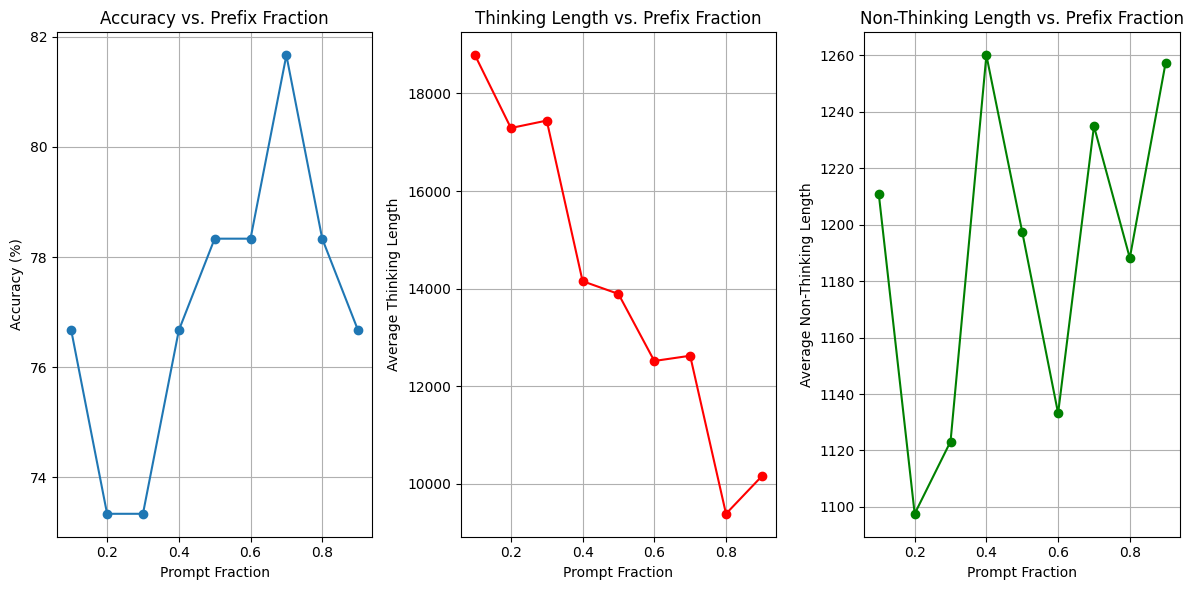

Previous model deleted and GPU cache cleared.


In [15]:
def set_seed(seed_value):
    """Set seed for reproducibility."""
    seed(seed_value)


def load_and_preprocess_aime_dataset(model_name, split="train"):
    """Loads and preprocesses the AIME dataset."""
    try:
        dataset = load_dataset("di-zhang-fdu/AIME_1983_2024", split=split)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        processed_data = []
        for example in dataset:
            question = example['Question']
            answer = example['Answer']
            year = example['Year']
            problem_number = example['Problem Number']
            problem_id = f"{year}-{problem_number}"
            question = question.replace("\\$", "$")
            answer = answer.replace("\\$", "$")
            input_prompt = (
                f"AIME Problem {problem_number} ({year}):\n{question}\n\n"
                "Solution:\nPlease reason step by step, and put your final answer within \\boxed{}.\n"
                "<think>\n"
            )
            tokenized_input = tokenizer(input_prompt, return_tensors="pt")
            processed_data.append({
                'problem': question,
                'solution': answer,
                'year': year,
                'problem_number': problem_number,
                'problem_id': problem_id,
                'input_prompt': input_prompt,
                'tokenized_input': tokenized_input,
            })
        print(f"Successfully processed {len(processed_data)} AIME problems")
        return processed_data, tokenizer
    except Exception as e:
        print(f"Error loading AIME dataset: {str(e)}")
        return None, None

def extract_thinking_trace(generated_text):
    """Extracts the thinking trace."""
    think_end = generated_text.find("</think>")
    if think_end != -1:
        thinking_trace = generated_text[:think_end + 8]
        thinking_trace_len = think_end + 8
        non_thinking_text = generated_text[think_end + 8:]
        non_thinking_len = len(non_thinking_text)
        return thinking_trace, thinking_trace_len, non_thinking_len
    else:
        return "", len(generated_text), 0


def run_experiment_original(processed_data, model, tokenizer, num_examples, sampling_params):
    """Runs the original experiment (no augmentation)."""
    batch_prompts = [example["input_prompt"] for example in processed_data[:num_examples]]
    results = model.generate(batch_prompts, sampling_params)
    thinking_trace_lengths = []
    non_thinking_lengths = []
    correct_count = 0
    total = 0
    generated_thinking_traces = []

    for idx, (example, result) in enumerate(zip(processed_data[:num_examples], results)):
        generated_text = result.outputs[0].text
        final_answer = extract_boxed_answer(generated_text)
        think_trace, think_len, non_think_len = extract_thinking_trace(generated_text)
        thinking_trace_lengths.append(think_len)
        non_thinking_lengths.append(non_think_len)
        generated_thinking_traces.append(think_trace)  # Store for later use
        ground_truth = example["solution"].strip().lower()
        extracted = final_answer.strip().lower() if final_answer else ""
        if extracted == ground_truth:
            correct_count += 1
        total += 1

    avg_thinking_trace_len = sum(thinking_trace_lengths) / len(thinking_trace_lengths) if thinking_trace_lengths else 0
    avg_non_thinking_len = sum(non_thinking_lengths) / len(non_thinking_lengths) if non_thinking_lengths else 0
    accuracy = (correct_count / total) * 100 if total > 0 else 0.0

    return results, accuracy, avg_thinking_trace_len, avg_non_thinking_len, generated_thinking_traces


def run_experiment_prefix_injection(processed_data, model, tokenizer, num_examples, sampling_params, thinking_prompts, thinking_prompt_fraction):
    """Runs experiment with prefix injection."""
    batch_prompts = []
    for i, example in enumerate(processed_data[:num_examples]):
        prompt_to_inject = thinking_prompts[i]
        inject_len = int(len(prompt_to_inject) * thinking_prompt_fraction)
        injected_prompt = prompt_to_inject[:inject_len]  # Prefix injection

        input_prompt = (
            f"AIME Problem {example['problem_number']} ({example['year']}):\n{example['problem']}\n\n"
            f"Solution:\n<think>\n{injected_prompt}"
        )
        batch_prompts.append(input_prompt)

    results = model.generate(batch_prompts, sampling_params)
    thinking_trace_lengths = []
    non_thinking_lengths = []
    correct_count = 0
    total = 0

    for idx, (example, result) in enumerate(zip(processed_data[:num_examples], results)):
        generated_text = result.outputs[0].text
        final_answer = extract_boxed_answer(generated_text)
        think_trace, think_len, non_think_len = extract_thinking_trace(generated_text)
        thinking_trace_lengths.append(think_len)
        non_thinking_lengths.append(non_think_len)
        ground_truth = example["solution"].strip().lower()
        extracted = final_answer.strip().lower() if final_answer else ""
        if extracted == ground_truth:
            correct_count += 1
        total += 1

    avg_thinking_trace_len = sum(thinking_trace_lengths) / len(thinking_trace_lengths) if thinking_trace_lengths else 0
    avg_non_thinking_len = sum(non_thinking_lengths) / len(non_thinking_lengths) if non_thinking_lengths else 0
    accuracy = (correct_count / total) * 100 if total > 0 else 0.0

    return results, accuracy, avg_thinking_trace_len, avg_non_thinking_len


# --- Colab Setup and Execution ---

model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
processed_data, tokenizer = load_and_preprocess_aime_dataset(model_name, split="train")
if processed_data is None:
    raise ValueError("Dataset loading failed.")
set_seed(42)
model = LLM(model=model_name, max_model_len=16048)
temperature = 0.6
top_p = 0.95
max_new_tokens = 15000
num_examples = 60
sampling_params = SamplingParams(temperature=temperature, top_p=top_p, max_tokens=max_new_tokens)

print("Running Experiment 1: No Prompt Augmentation")
results_exp1, accuracy_exp1, avg_think_len_exp1, avg_non_think_len_exp1, thinking_prompts_exp1 = run_experiment_original(
    processed_data, model, tokenizer, num_examples, sampling_params
)
print(f"Accuracy (Experiment 1): {accuracy_exp1:.2f}%")
print(f"Average thinking trace length (Experiment 1): {avg_think_len_exp1:.2f} characters")
print(f"Average non-thinking text length (Experiment 1): {avg_non_think_len_exp1:.2f} characters")


# --- Experiment 2: Varying Prefix Fractions ---
print("\nRunning Experiment 2: With Varying Prefix Augmentation")
prompt_fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies_prefix = []
avg_thinking_lengths_prefix = []
avg_non_thinking_lengths_prefix = []

for fraction in prompt_fractions:
    results_exp2, accuracy_exp2, avg_think_len_exp2, avg_non_think_len_exp2 = run_experiment_prefix_injection(
        processed_data, model, tokenizer, num_examples, sampling_params,
        thinking_prompts_exp1, fraction
    )
    accuracies_prefix.append(accuracy_exp2)
    avg_thinking_lengths_prefix.append(avg_think_len_exp2)
    avg_non_thinking_lengths_prefix.append(avg_non_think_len_exp2)
    print(f"Fraction: {fraction}, Accuracy: {accuracy_exp2:.2f}%, Think Len: {avg_think_len_exp2:.2f}, Non-Think Len: {avg_non_think_len_exp2:.2f}")


# --- Plotting and Saving (Prefix Injection) ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(prompt_fractions, accuracies_prefix, marker='o')
plt.xlabel('Prompt Fraction')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Prefix Fraction')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(prompt_fractions, avg_thinking_lengths_prefix, marker='o', color='r')
plt.xlabel('Prompt Fraction')
plt.ylabel('Average Thinking Length')
plt.title('Thinking Length vs. Prefix Fraction')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(prompt_fractions, avg_non_thinking_lengths_prefix, marker='o', color='g')
plt.xlabel('Prompt Fraction')
plt.ylabel('Average Non-Thinking Length')
plt.title('Non-Thinking Length vs. Prefix Fraction')
plt.grid(True)

plt.tight_layout()

output_dir_prefix = "plot_results_prefix"
if not os.path.exists(output_dir_prefix):
    os.makedirs(output_dir_prefix)

plt.savefig(os.path.join(output_dir_prefix, "combined_plots_prefix.png"))

plt.subplot(1, 3, 1); plt.savefig(os.path.join(output_dir_prefix, "accuracy_plot_prefix.png"))
plt.subplot(1, 3, 2); plt.savefig(os.path.join(output_dir_prefix, "thinking_length_plot_prefix.png"))
plt.subplot(1, 3, 3); plt.savefig(os.path.join(output_dir_prefix, "non_thinking_length_plot_prefix.png"))


plt.show()

try:
    del model
    del sampling_params
    gc.collect()
    torch.cuda.empty_cache()
    print("Previous model deleted and GPU cache cleared.")
except Exception as e:
    print("Error clearing previous model:", e)



## Random insertions of thinking traces

Successfully processed 933 AIME problems
INFO 02-27 21:07:17 config.py:549] This model supports multiple tasks: {'classify', 'embed', 'generate', 'reward', 'score'}. Defaulting to 'generate'.
INFO 02-27 21:07:17 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=16048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_t

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 02-27 21:07:21 model_runner.py:1115] Loading model weights took 14.9576 GB
INFO 02-27 21:07:22 worker.py:267] Memory profiling takes 0.63 seconds
INFO 02-27 21:07:22 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.90) = 71.27GiB
INFO 02-27 21:07:22 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 1.66GiB; the rest of the memory reserved for KV Cache is 54.66GiB.
INFO 02-27 21:07:22 executor_base.py:111] # cuda blocks: 27984, # CPU blocks: 2048
INFO 02-27 21:07:22 executor_base.py:116] Maximum concurrency for 16048 tokens per request: 27.90x
INFO 02-27 21:07:22 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:17<00:00,  2.03it/s]

INFO 02-27 21:07:39 model_runner.py:1562] Graph capturing finished in 17 secs, took 0.09 GiB
INFO 02-27 21:07:40 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 18.39 seconds


Running Experiment 1: No Prompt Augmentation


Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   8%|▊         | 15/200 [01:14<05:58,  1.94s/it, est. speed input: 24.26 toks/s, output: 384.84 toks/s]

WARNING 02-27 21:08:55 scheduler.py:1754] Sequence group 199 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts:  26%|██▋       | 53/200 [02:21<02:37,  1.07s/it, est. speed input: 37.81 toks/s, output: 1044.82 toks/s]

WARNING 02-27 21:10:05 scheduler.py:1754] Sequence group 151 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51


Processed prompts:  62%|██████▎   | 125/200 [06:22<04:06,  3.29s/it, est. speed input: 37.27 toks/s, output: 1674.61 toks/s]

WARNING 02-27 21:14:14 scheduler.py:1754] Sequence group 164 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


Processed prompts: 100%|██████████| 200/200 [11:40<00:00,  3.50s/it, est. speed input: 34.18 toks/s, output: 2108.92 toks/s]


Accuracy (Experiment 1): 74.50%
Average thinking trace length (Experiment 1): 20396.72 characters
Average non-thinking text length (Experiment 1): 1244.03 characters

Running Experiment 2: With Varying Prompt Augmentation


Processed prompts:  36%|███▌      | 71/200 [02:08<03:34,  1.66s/it, est. speed input: 250.36 toks/s, output: 1250.50 toks/s]

WARNING 02-27 21:21:30 scheduler.py:1754] Sequence group 368 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=151


Processed prompts:  74%|███████▍  | 149/200 [06:01<03:03,  3.61s/it, est. speed input: 253.96 toks/s, output: 1737.05 toks/s]

WARNING 02-27 21:25:32 scheduler.py:1754] Sequence group 397 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=201


Processed prompts: 100%|██████████| 200/200 [10:14<00:00,  3.07s/it, est. speed input: 192.08 toks/s, output: 2052.17 toks/s]


Fraction: 0.1, Accuracy: 72.00%, Think Len: 17457.03, Non-Think Len: 1068.52


Processed prompts:  47%|████▋     | 94/200 [02:20<00:54,  1.95it/s, est. speed input: 736.17 toks/s, output: 1491.38 toks/s]

WARNING 02-27 21:31:58 scheduler.py:1754] Sequence group 591 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=251


Processed prompts: 100%|██████████| 200/200 [09:08<00:00,  2.74s/it, est. speed input: 393.58 toks/s, output: 2035.82 toks/s]


Fraction: 0.2, Accuracy: 71.50%, Think Len: 15338.76, Non-Think Len: 1042.70


Processed prompts:  12%|█▏        | 23/200 [00:59<04:37,  1.57s/it, est. speed input: 823.59 toks/s, output: 304.34 toks/s]

WARNING 02-27 21:39:45 scheduler.py:1754] Sequence group 781 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=301


Processed prompts: 100%|██████████| 200/200 [07:49<00:00,  2.35s/it, est. speed input: 670.20 toks/s, output: 2047.66 toks/s] 


Fraction: 0.3, Accuracy: 71.00%, Think Len: 12679.11, Non-Think Len: 1096.30


Processed prompts:  10%|▉         | 19/200 [00:43<04:20,  1.44s/it, est. speed input: 1427.79 toks/s, output: 207.20 toks/s]

WARNING 02-27 21:47:19 scheduler.py:1754] Sequence group 985 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=351


Processed prompts: 100%|██████████| 200/200 [07:34<00:00,  2.27s/it, est. speed input: 909.71 toks/s, output: 1883.51 toks/s] 


Fraction: 0.4, Accuracy: 71.00%, Think Len: 11309.17, Non-Think Len: 1004.42


Processed prompts:  15%|█▌        | 30/200 [00:54<04:39,  1.65s/it, est. speed input: 2132.88 toks/s, output: 338.78 toks/s]

WARNING 02-27 21:55:05 scheduler.py:1754] Sequence group 1167 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=401


Processed prompts: 100%|██████████| 200/200 [07:39<00:00,  2.30s/it, est. speed input: 1109.21 toks/s, output: 1760.35 toks/s]


Fraction: 0.5, Accuracy: 75.00%, Think Len: 10465.16, Non-Think Len: 1125.33


Processed prompts: 100%|██████████| 200/200 [07:40<00:00,  2.30s/it, est. speed input: 1326.44 toks/s, output: 1653.20 toks/s]


Fraction: 0.6, Accuracy: 75.50%, Think Len: 9863.35, Non-Think Len: 1050.22


Processed prompts: 100%|██████████| 200/200 [06:44<00:00,  2.02s/it, est. speed input: 1752.01 toks/s, output: 1564.62 toks/s]


Fraction: 0.7, Accuracy: 74.50%, Think Len: 7902.85, Non-Think Len: 1103.30


Processed prompts: 100%|██████████| 200/200 [07:09<00:00,  2.15s/it, est. speed input: 1869.31 toks/s, output: 1470.86 toks/s]


Fraction: 0.8, Accuracy: 76.00%, Think Len: 8044.10, Non-Think Len: 1123.61


Processed prompts: 100%|██████████| 200/200 [06:40<00:00,  2.00s/it, est. speed input: 2242.55 toks/s, output: 1416.32 toks/s]


Fraction: 0.9, Accuracy: 75.50%, Think Len: 7174.97, Non-Think Len: 1089.68


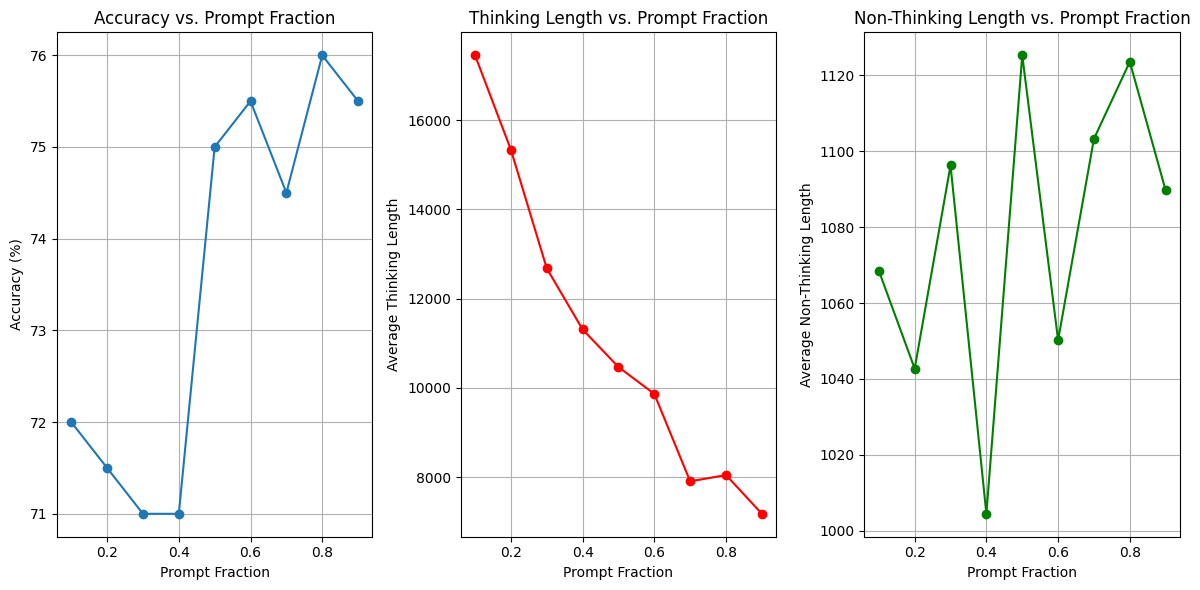

In [12]:
def extract_thinking_trace(generated_text):
    """Extracts the thinking trace."""
    think_end = generated_text.find("</think>")
    if think_end != -1:
        thinking_trace = generated_text[:think_end + 8]
        thinking_trace_len = think_end + 8
        non_thinking_text = generated_text[think_end + 8:]
        non_thinking_len = len(non_thinking_text)
        return thinking_trace, thinking_trace_len, non_thinking_len
    else:
        return "", len(generated_text), 0

def inject_random_segment(full_prompt, inject_len):
    """Injects a random segment."""
    if inject_len <= 0 or inject_len > len(full_prompt):
        return ""
    start_index = randint(0, len(full_prompt) - inject_len)
    return full_prompt[start_index:start_index + inject_len]

def run_experiment_original(processed_data, model, tokenizer, num_examples, sampling_params):
    """Runs the original experiment (no augmentation)."""
    batch_prompts = [example["input_prompt"] for example in processed_data[:num_examples]]
    results = model.generate(batch_prompts, sampling_params)
    thinking_trace_lengths = []
    non_thinking_lengths = []
    correct_count = 0
    total = 0
    generated_thinking_traces = []

    for idx, (example, result) in enumerate(zip(processed_data[:num_examples], results)):
        generated_text = result.outputs[0].text
        final_answer = extract_boxed_answer(generated_text)
        think_trace, think_len, non_think_len = extract_thinking_trace(generated_text)
        thinking_trace_lengths.append(think_len)
        non_thinking_lengths.append(non_think_len)
        generated_thinking_traces.append(think_trace)
        ground_truth = example["solution"].strip().lower()
        extracted = final_answer.strip().lower() if final_answer else ""
        if extracted == ground_truth:
            correct_count += 1
        total += 1

    avg_thinking_trace_len = sum(thinking_trace_lengths) / len(thinking_trace_lengths) if thinking_trace_lengths else 0
    avg_non_thinking_len = sum(non_thinking_lengths) / len(non_thinking_lengths) if non_thinking_lengths else 0
    accuracy = (correct_count / total) * 100 if total > 0 else 0.0

    return results, accuracy, avg_thinking_trace_len, avg_non_thinking_len, generated_thinking_traces


def run_experiment_random_injection(processed_data, model, tokenizer, num_examples, sampling_params, thinking_prompts, thinking_prompt_fraction):
    """Runs experiment with random injection."""
    batch_prompts = []
    for i, example in enumerate(processed_data[:num_examples]):
        prompt_to_inject = thinking_prompts[i]
        inject_len = int(len(prompt_to_inject) * thinking_prompt_fraction)
        injected_prompt = inject_random_segment(prompt_to_inject, inject_len)

        input_prompt = (
            f"AIME Problem {example['problem_number']} ({example['year']}):\n{example['problem']}\n\n"
            "Solution:\n<think>\n"
            "******\n"
            f"\n{injected_prompt}\n"
            "******\n"
            "</think>\n"
        )
        batch_prompts.append(input_prompt)

    results = model.generate(batch_prompts, sampling_params)
    thinking_trace_lengths = []
    non_thinking_lengths = []
    correct_count = 0
    total = 0

    for idx, (example, result) in enumerate(zip(processed_data[:num_examples], results)):
        generated_text = result.outputs[0].text
        final_answer = extract_boxed_answer(generated_text)
        think_trace, think_len, non_think_len = extract_thinking_trace(generated_text)
        thinking_trace_lengths.append(think_len)
        non_thinking_lengths.append(non_think_len)
        ground_truth = example["solution"].strip().lower()
        extracted = final_answer.strip().lower() if final_answer else ""
        if extracted == ground_truth:
            correct_count += 1
        total += 1

    avg_thinking_trace_len = sum(thinking_trace_lengths) / len(thinking_trace_lengths) if thinking_trace_lengths else 0
    avg_non_thinking_len = sum(non_thinking_lengths) / len(non_thinking_lengths) if non_thinking_lengths else 0
    accuracy = (correct_count / total) * 100 if total > 0 else 0.0

    return results, accuracy, avg_thinking_trace_len, avg_non_thinking_len




model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
processed_data, tokenizer = load_and_preprocess_aime_dataset(model_name, split="train")
if processed_data is None:
    raise ValueError("Dataset loading failed.")
set_seed(42)
model = LLM(model=model_name, max_model_len=16048)
temperature = 0.6
top_p = 0.95
max_new_tokens = 15000
num_examples = 200
sampling_params = SamplingParams(temperature=temperature, top_p=top_p, max_tokens=max_new_tokens)

print("Running Experiment 1: No Prompt Augmentation")
results_exp1, accuracy_exp1, avg_think_len_exp1, avg_non_think_len_exp1, thinking_prompts_exp1 = run_experiment_original(
    processed_data, model, tokenizer, num_examples, sampling_params
)
print(f"Accuracy (Experiment 1): {accuracy_exp1:.2f}%")
print(f"Average thinking trace length (Experiment 1): {avg_think_len_exp1:.2f} characters")
print(f"Average non-thinking text length (Experiment 1): {avg_non_think_len_exp1:.2f} characters")


# --- Experiment 2: Varying Prompt Fractions ---
print("\nRunning Experiment 2: With Varying Prompt Augmentation")
prompt_fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []
avg_thinking_lengths = []
avg_non_thinking_lengths = []

for fraction in prompt_fractions:
    results_exp2, accuracy_exp2, avg_think_len_exp2, avg_non_think_len_exp2 = run_experiment_random_injection(
        processed_data, model, tokenizer, num_examples, sampling_params,
        thinking_prompts_exp1, fraction
    )
    accuracies.append(accuracy_exp2)
    avg_thinking_lengths.append(avg_think_len_exp2)
    avg_non_thinking_lengths.append(avg_non_think_len_exp2)
    print(f"Fraction: {fraction}, Accuracy: {accuracy_exp2:.2f}%, Think Len: {avg_think_len_exp2:.2f}, Non-Think Len: {avg_non_think_len_exp2:.2f}")

# --- Plotting and Saving ---
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(prompt_fractions, accuracies, marker='o')
plt.xlabel('Prompt Fraction')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Prompt Fraction')
plt.grid(True)

# Average Thinking Length Plot
plt.subplot(1, 3, 2)
plt.plot(prompt_fractions, avg_thinking_lengths, marker='o', color='r')
plt.xlabel('Prompt Fraction')
plt.ylabel('Average Thinking Length')
plt.title('Thinking Length vs. Prompt Fraction')
plt.grid(True)

# Average Non-Thinking Length Plot
plt.subplot(1, 3, 3)
plt.plot(prompt_fractions, avg_non_thinking_lengths, marker='o', color='g')
plt.xlabel('Prompt Fraction')
plt.ylabel('Average Non-Thinking Length')
plt.title('Non-Thinking Length vs. Prompt Fraction')
plt.grid(True)

plt.tight_layout()

# Create a directory to save the plots if it doesn't exist
output_dir = "plot_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the entire figure
plt.savefig(os.path.join(output_dir, "combined_plots.png"))

# Save individual plots
plt.subplot(1, 3, 1)  # Select the accuracy plot
plt.savefig(os.path.join(output_dir, "accuracy_plot.png"))

plt.subplot(1, 3, 2)  # Select the thinking length plot
plt.savefig(os.path.join(output_dir, "thinking_length_plot.png"))

plt.subplot(1, 3, 3)  # Select the non-thinking length plot
plt.savefig(os.path.join(output_dir, "non_thinking_length_plot.png"))


plt.show()  # Display the plots (optional, but good for Colab)


In [13]:
try:
    del model
    del sampling_params
    gc.collect()
    torch.cuda.empty_cache()
    print("Previous model deleted and GPU cache cleared.")
except Exception as e:
    print("Error clearing previous model:", e)


Previous model deleted and GPU cache cleared.


In [14]:
!nvidia-smi

Thu Feb 27 22:30:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          Off |   00000000:03:00.0 Off |                    0 |
| N/A   44C    P0            138W /  700W |    1125MiB /  81559MiB |    100%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
